# CBIS-DDSM: Breast Cancer Image Dataset

## Lectura de datos 
Tomado de 

https://www.kaggle.com/code/baselanaya/breast-cancer-detection-using-cnn?cellIds=34&kernelSessionId=144188816


In [13]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [6]:
dicom_data = pd.read_csv('csv/dicom_info.csv')
image_dir = 'jpeg'

In [7]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [8]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

Trabajando con datos médicos en formato DICOM (Digital Imaging and Communications in Medicine). Vamos a descomponerlo para entenderlo paso a paso:

   - **cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path:** Esta línea de código filtra los datos contenidos en dicom_data. Aquí hay una explicación detallada de lo que hace:

   - **dicom_data:** Supongamos que dicom_data es un DataFrame de pandas que contiene información relacionada con imágenes médicas en formato DICOM. Cada fila del DataFrame representa una imagen médica y contiene columnas que describen varias propiedades de la imagen, como su descripción, ruta de archivo, etc.

   - **dicom_data.SeriesDescription == 'cropped images':** Esto crea una máscara booleana que evalúa si la columna SeriesDescription del DataFrame es igual a la cadena 'cropped images'. La máscara tiene el mismo número de filas que el DataFrame original y contiene True en las filas donde la condición se cumple y False en las demás.

   - **dicom_data[dicom_data.SeriesDescription == 'cropped images']:** Aplica la máscara booleana al DataFrame original para seleccionar solo las filas donde SeriesDescription es igual a 'cropped images'. En otras palabras, esto filtra el DataFrame original para retener solo las filas que corresponden a imágenes médicas con la descripción 'cropped images'.

   - **.image_path:** Una vez que se ha aplicado la máscara y se ha obtenido un subconjunto del DataFrame, se accede a la columna image_path de ese subconjunto. Esto devuelve una serie de pandas que contiene las rutas de archivo de las imágenes médicas que cumplen con la condición.

   - **cropped_images.head():** Esto muestra las primeras filas de la serie cropped_images, que contiene las rutas de archivo de las imágenes médicas con la descripción 'cropped images'.

En resumen, esta línea de código filtra y selecciona las rutas de archivo de imágenes médicas que tienen la descripción 'cropped images' en el DataFrame dicom_data, y luego muestra las primeras filas de esas rutas de archivo. Esto puede ser útil para acceder y procesar específicamente las imágenes con esa descripción particular en tu conjunto de datos DICOM.

In [9]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [10]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     jpeg/1.3.6.1.4.1.9590.100.1.2.1293087268128519...
3     jpeg/1.3.6.1.4.1.9590.100.1.2.3811873696115245...
6     jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
7     jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
10    jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...
Name: image_path, dtype: object

Es un bucle que procesa las primeras 1000 imágenes contenidas en la serie cropped_images. Aquí está la descripción de lo que hace paso a paso:

- **for file in cropped_images[0:10]::** Este bucle for itera a través de las primeras 10 rutas de archivo de imágenes médicas contenidas en la serie cropped_images.

- **cropped_images_show = PIL.Image.open(file):** Dentro del bucle, se utiliza la biblioteca PIL (Python Imaging Library) para abrir cada imagen. La ruta de archivo de la imagen actual se almacena en la variable file. La imagen se abre utilizando PIL.Image.open(file) y se guarda en la variable cropped_images_show.

- **gray_img = cropped_images_show.convert("L"):** Después de abrir la imagen, se convierte a escala de grises utilizando el método .convert("L") de la biblioteca PIL. Esto significa que la imagen se representará en blanco y negro en lugar de color.

- **plt.imshow(gray_img, cmap='gray'):** Finalmente, se utiliza Matplotlib (plt) para mostrar la imagen en escala de grises. La función plt.imshow() se utiliza para mostrar la imagen, y se especifica cmap='gray' para asegurarse de que se muestre correctamente en escala de grises.

En resumen, este bucle procesa y muestra las primeras 1000 imágenes médicas con la descripción 'cropped images' en escala de grises utilizando la biblioteca PIL y Matplotlib. Cada imagen se carga, se convierte a escala de grises y se muestra en una ventana gráfica. Esto puede ser útil para visualizar y analizar las imágenes médicas contenidas en el conjunto de datos.

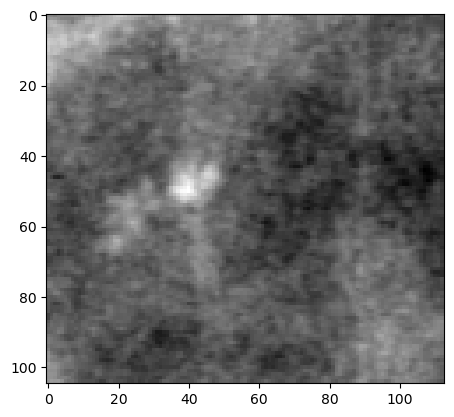

In [19]:
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [17]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [18]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     jpeg/1.3.6.1.4.1.9590.100.1.2.2483867420106785...
2     jpeg/1.3.6.1.4.1.9590.100.1.2.2672131710111718...
11    jpeg/1.3.6.1.4.1.9590.100.1.2.2103968939112343...
12    jpeg/1.3.6.1.4.1.9590.100.1.2.7495665831138395...
15    jpeg/1.3.6.1.4.1.9590.100.1.2.9876588541294641...
Name: image_path, dtype: object

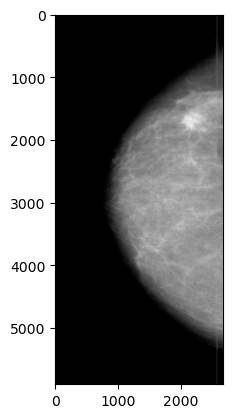

In [20]:
for file  in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [25]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [26]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     jpeg/1.3.6.1.4.1.9590.100.1.2.1533390529131213...
8     jpeg/1.3.6.1.4.1.9590.100.1.2.1789947146114851...
9     jpeg/1.3.6.1.4.1.9590.100.1.2.4118334926123736...
14    jpeg/1.3.6.1.4.1.9590.100.1.2.2363735487129941...
20    jpeg/1.3.6.1.4.1.9590.100.1.2.3570080504125347...
Name: image_path, dtype: object

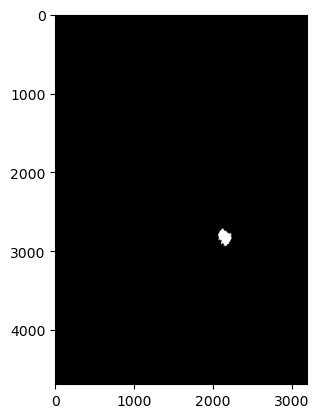

In [27]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [28]:
calc_case_df = pd.read_csv('csv/calc_case_description_train_set.csv')
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [29]:
mass_case_df = pd.read_csv('csv/mass_case_description_train_set.csv')
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [30]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [31]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [32]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [33]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [34]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [35]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [36]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [37]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

# Al parecer solo necesitamos desde acá
Toca descargar esto, pero lo anterior me pareció nice por eso no lo borré. 

https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/data

https://www.kaggle.com/code/baselanaya/breast-cancer-detection-using-cnn?cellIds=34&kernelSessionId=144188816

In [14]:
breast_imgs = glob.glob('breast-histopathology-images/IDC_regular_ps50_idx5/**/**.png', recursive = True)

In [15]:
for imgname in breast_imgs[:5]:
    print(imgname)    

breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png


In [31]:
import shutil

In [62]:
non_cancer_imgs = []
cancer_imgs = []

carpeta_cancer = 'cancer/'
carpeta_nocancer = 'no-cancer/'
for img in breast_imgs:
    if img[-5] == '0' :
        #shutil.copy(img, carpeta_cancer)
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        #shutil.copy(img, carpeta_nocancer)
        cancer_imgs.append(img)

In [63]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Número de imágenes sin cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Número de imágenes cancer : {}' .format(cancer_num))   # images of cancer 
print('Total de imágenes : {}' .format(total_img_num))

Número de imágenes sin cancer: 198738
Número de imágenes cancer : 78786
Total de imágenes : 277524


In [34]:
entrenamiento_cancer = 'entrenamiento/cancer/'
entrenamiento_nocancer = 'entrenamiento/nocancer/'
test_cancer = 'test/cancer/'
test_nocancer = 'test/nocancer/'

In [37]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)



Separamos los datos en entrenamiento y test (solo hacerlo una vez)

In [38]:
split_size = .8

split_data(carpeta_cancer, entrenamiento_cancer, test_cancer, split_size)
split_data(carpeta_nocancer, entrenamiento_nocancer, test_nocancer, split_size)


In [74]:
entrenamiento_cancer = 'entrenamiento/cancer/'
entrenamiento_nocancer = 'entrenamiento/nocancer/'
test_cancer = 'test/cancer/'
test_nocancer = 'test/nocancer/'

datos_entrenamiento_cancer = glob.glob('entrenamiento/cancer/**.png', recursive = True)
datos_entrenamiento_nocancer = glob.glob('entrenamiento/nocancer/**.png', recursive = True)
datos_test_cancer = glob.glob('test/cancer/**.png', recursive = True)
datos_test_nocancer = glob.glob('test/nocancer/**.png', recursive = True)


print('Imágenes de entrenamiento sin cancer: {}' .format(len(datos_entrenamiento_cancer)))
print('Imágenes de entrenamiento con cancer: {}' .format(len(datos_entrenamiento_nocancer)))
print('Imágenes de entrenamiento total: {}' .format(len(datos_entrenamiento_nocancer)+len(datos_entrenamiento_cancer)))
print('Imágenes de test sin cancer: {}' .format(len(datos_test_cancer)))
print('Imágenes de test con cancer: {}' .format(len(datos_test_nocancer)))
print('Imágenes de test total: {}' .format(len(datos_test_nocancer)+len(datos_test_cancer)))

Imágenes de entrenamiento sin cancer: 158990
Imágenes de entrenamiento con cancer: 63028
Imágenes de entrenamiento total: 222018
Imágenes de test sin cancer: 39748
Imágenes de test con cancer: 15758
Imágenes de test total: 55506


# RNC 1

In [44]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
TRAINING_DIR = "entrenamiento/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "test/"

validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 222018 images belonging to 2 classes.
Found 55506 images belonging to 2 classes.


In [77]:
history = model.fit(train_generator,
                              steps_per_epoch= 2,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/10
2/2 [==============================] - 245s 244s/step - loss: 0.3197 - accuracy: 0.8550 - val_loss: 0.3780 - val_accuracy: 0.8392
Epoch 2/10
2/2 [==============================] - 245s 244s/step - loss: 0.2716 - accuracy: 0.8900 - val_loss: 0.3622 - val_accuracy: 0.8461
Epoch 3/10
2/2 [==============================] - 257s 256s/step - loss: 0.4021 - accuracy: 0.8300 - val_loss: 0.3639 - val_accuracy: 0.8411
Epoch 4/10
2/2 [==============================] - 240s 239s/step - loss: 0.3443 - accuracy: 0.8700 - val_loss: 0.4106 - val_accuracy: 0.8299
Epoch 5/10
2/2 [==============================] - 1908s 1907s/step - loss: 0.4407 - accuracy: 0.8100 - val_loss: 0.3587 - val_accuracy: 0.8436
Epoch 6/10
2/2 [==============================] - 241s 240s/step - loss: 0.3323 - accuracy: 0.8850 - val_loss: 0.3520 - val_accuracy: 0.8503
Epoch 7/10
2/2 [==============================] - 243s 242s/step - loss: 0.3323 - accuracy: 0.8650 - val_loss: 0.3571 - val_accuracy: 0.8458
Epoch 8/10


In [56]:
# Para probar
history = model.fit(train_generator,
                              steps_per_epoch= 10,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/2
10/10 [==============================] - 244s 27s/step - loss: 0.3615 - accuracy: 0.8580 - val_loss: 0.3584 - val_accuracy: 0.8447
Epoch 2/2
10/10 [==============================] - 251s 28s/step - loss: 0.3471 - accuracy: 0.8530 - val_loss: 0.3753 - val_accuracy: 0.8387


In [51]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [78]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


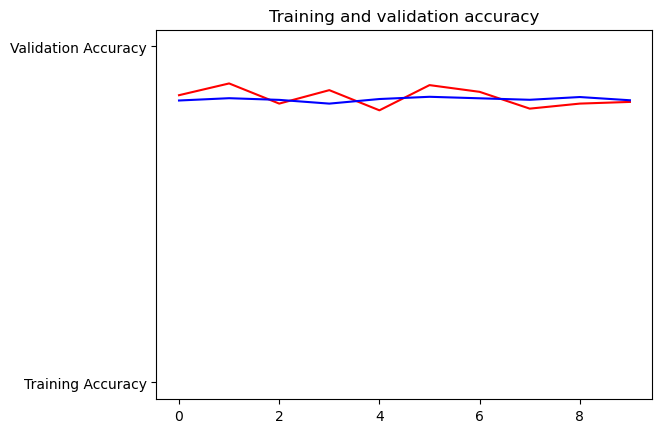

In [79]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()


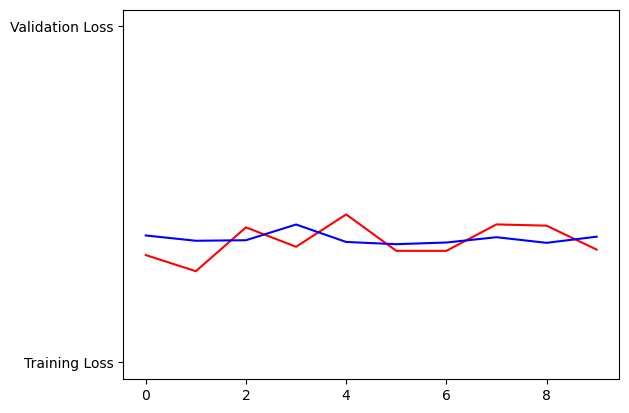

In [80]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()
# Desired output. Charts with training and validation metrics. No crash :)

# RNC

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [20]:
clf = Sequential()
# Capa convolucional 1
clf.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(255, 255, 3), activation="relu"))

# Max pooling - Capa de submuestreo
clf.add(MaxPooling2D(pool_size = (2,2)))
# Average pooling

# Flattening - Aplanamiento
clf.add(Flatten())

# Full connection - Capas conectadas
clf.add(Dense(units = 128, activation = "relu"))
clf.add(Dense(units = 1, activation = "sigmoid"))

# Compilar CNN
clf.compile(optimizer = "adam", loss = "binary_crossentropy",
           metrics = ["accuracy"])

In [21]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

# Cargar carpeta de trabajo, training
train_generator = train_datagen.flow_from_directory('deeplearning-az-master/original/Part 2 - Convolutional Neural Networks (CNN)/dataset/training_set',
                                                    target_size=(64, 64), # mantener el tamaño de la entrada de la RCC, escalar la imagen
                                                    batch_size=32,        # Cantidad de imagenes que van a pasar por la RCC, va de 32 en 32
                                                    class_mode='binary')  # las categorías que tenemos